## Part 1 Asset Allocation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import riskfolio as rp

from numpy.linalg import inv
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.black_litterman import BlackLittermanModel
from pypfopt.hierarchical_portfolio import HRPOpt
from pypfopt import objective_functions

## 1 Load Data
- Loading the data & align to quaterly frequency

In [2]:
# Load Data
df_monthly = pd.read_excel(f"./Data for case study part1.xlsx", sheet_name=1, index_col=0)
df_quaterly = pd.read_excel(f"./Data for case study part1.xlsx", sheet_name=2, index_col=0)

df_monthly.index = pd.to_datetime(df_monthly.index)
df_quaterly.index = pd.to_datetime(df_quaterly.index)
df_monthly.index.name='time'
df_quaterly.index.name='time'

# Align to quaterly Frequency
df_data = pd.merge(df_monthly, df_quaterly, how='right', on='time')

## 2 Asset Allocation Preparation
- Setting the global configurations

In [3]:
# config
# precision float64

n_assets = df_data.shape[1]
T = df_data.shape[0]
quarterly_conversion_factor = 4

lamda = 20
r = 0.02

asset_weights_benchmark = np.array([0.3, 0.2, 0.3, 0.2, 0]) # The GIC baseline allocation

# calculate hitorical returns
assets_return = df_data.mean().values 
assets_cov = df_data.cov().values
assets_ones = np.ones(n_assets)

# for poltting
zero_series = pd.Series([0]*df_data.shape[0], index=df_data.index)

In [4]:
# define the functions we need
def analyze_performance(asset_weights):
    return_portfolio = (assets_return @ asset_weights) * quarterly_conversion_factor
    volatility_portfolio= np.sqrt((asset_weights @ assets_cov @ asset_weights) * quarterly_conversion_factor)
    sharpe_portfolio  = (return_portfolio - r)/ volatility_portfolio
    print(f"Annually Return {return_portfolio*100:.3f}%,\n Annually Volatility {volatility_portfolio*100:.3f}%,\n Sharpe {sharpe_portfolio:.3f}")
    
def plot_asset_weights(asset_weights, label=''):
    asset_weights = pd.DataFrame(asset_weights, index=df_data.columns)

    plt.figure(figsize = [6,6], dpi=50)
    ax = rp.plot_pie(w=asset_weights,
                     title=label,
                     others=0.05,
                     nrow=25,
                     cmap = "tab20",
                     height=6,
                     width=10,
                     ax=None)
    plt.show()

def plot_asset_returns(asset_weights, label=''):
    plt.figure(figsize=[18,5], dpi=200)
    plt.title(f"{label} Asset Returns")
    
    for index, col in enumerate(df_data.columns):
        plt.plot(df_data[col] * asset_weights[index] / n_assets, label=col)
    plt.plot(zero_series, label='zero', color='gray', linestyle='--')    
    plt.legend()
    # plt.savefig(f"./picture/{label}_asset_returns.png")
    plt.show()
    
    
def plot_portfolio_returns(asset_weights, label=''):
    fig,ax1 = plt.subplots(figsize=[18,5], dpi=200)
    plt.title(f"{label} Portfolio Returns & Cumulative Returns")

    plt.plot(zero_series, label='zero', color='gray', linestyle='--', linewidth=2)
    ax2 = ax1.twinx()           

    ax1.plot((df_data * asset_weights).mean(axis=1), label='returns', color='orange')
    ax1.set_ylabel('returns')
    ax1.legend()

    ax2.plot(((df_data * asset_weights).mean(axis=1) + 1).cumprod(), label='cumulative_returns')
    ax2.set_ylabel('cumulative_returns')
    ax2.legend()
    # plt.savefig(f"./picture/{label}_portfolio_returns.png")
    plt.show()

## 3 Black-Litterman Postier Estimation

In [5]:
# take historical return as the prior return 
prior_return = assets_return

# Adding Relative views “Private Credit will outperform Fixed Income by 2%”, the corresponding Q vector is:
Q = np.array([0.02]).reshape(-1, 1)

# The picking matrix
P = np.array(
    [
        [0, 0, -1, 0, 1],
    ]
)

# generate the postier estimate

bl = BlackLittermanModel(assets_cov, pi=prior_return, Q=Q, P=P, omega="idzorek", view_confidences=0.9)
posterior_returns = bl.bl_returns()
posterior_cov = bl.bl_cov()

assets_return = posterior_returns
assets_cov = posterior_cov.values

## 3 Markowitz Mean-Variance Framework
- Markowitz

In [6]:
ef = EfficientFrontier(assets_return, assets_cov, weight_bounds=[-1,1])
weights = ef.max_quadratic_utility(risk_aversion=lamda)
cleaned_weights = ef.clean_weights()
asset_weights_markowitz = pd.DataFrame(cleaned_weights, index=['weights']).values[0]
asset_weights_markowitz

array([-0.66431,  0.23901,  0.68981,  0.84884, -0.11335])

/Users/rickzhou/miniconda3/lib/python3.8/site-packages/riskfolio/src/PlotFunctions.py:605: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sizes2 = sizes2.append(item)


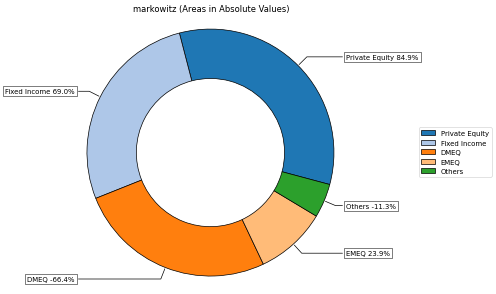

In [7]:
plot_asset_weights(asset_weights_markowitz, label='markowitz')

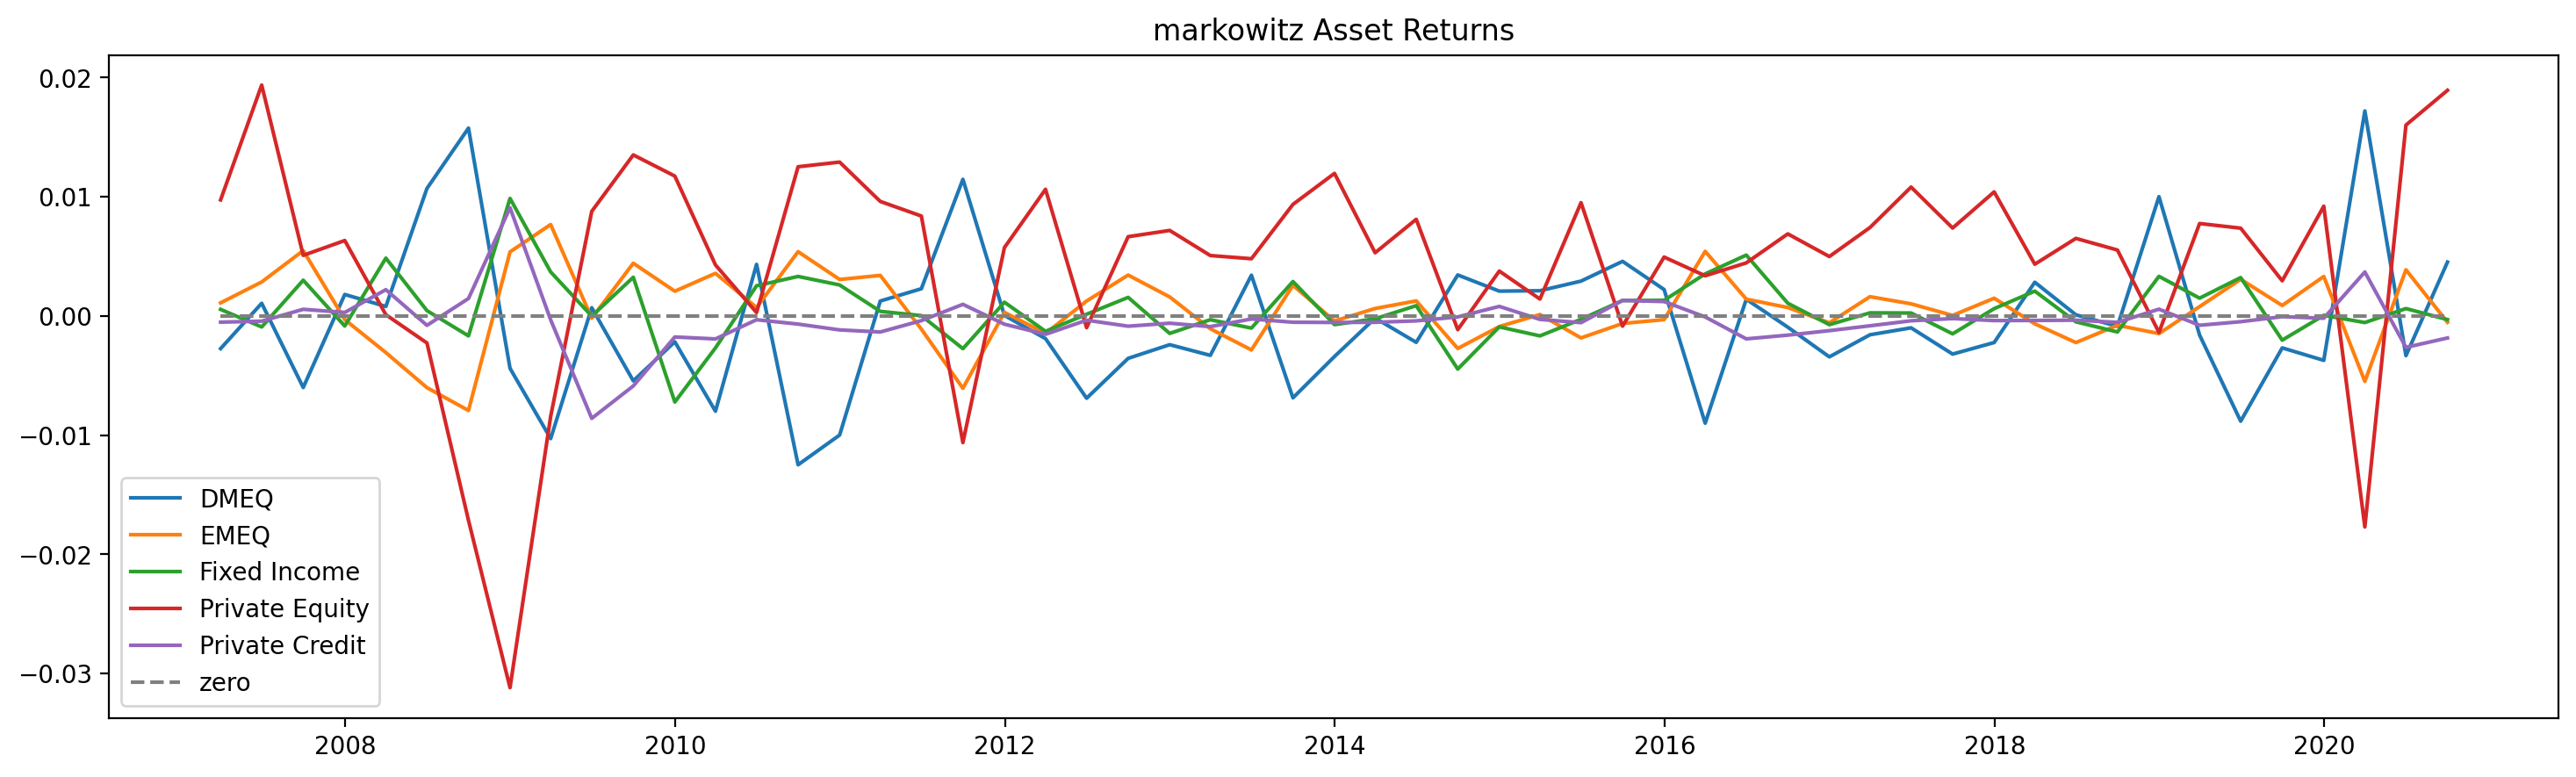

In [8]:
plot_asset_returns(asset_weights_markowitz, label='markowitz')

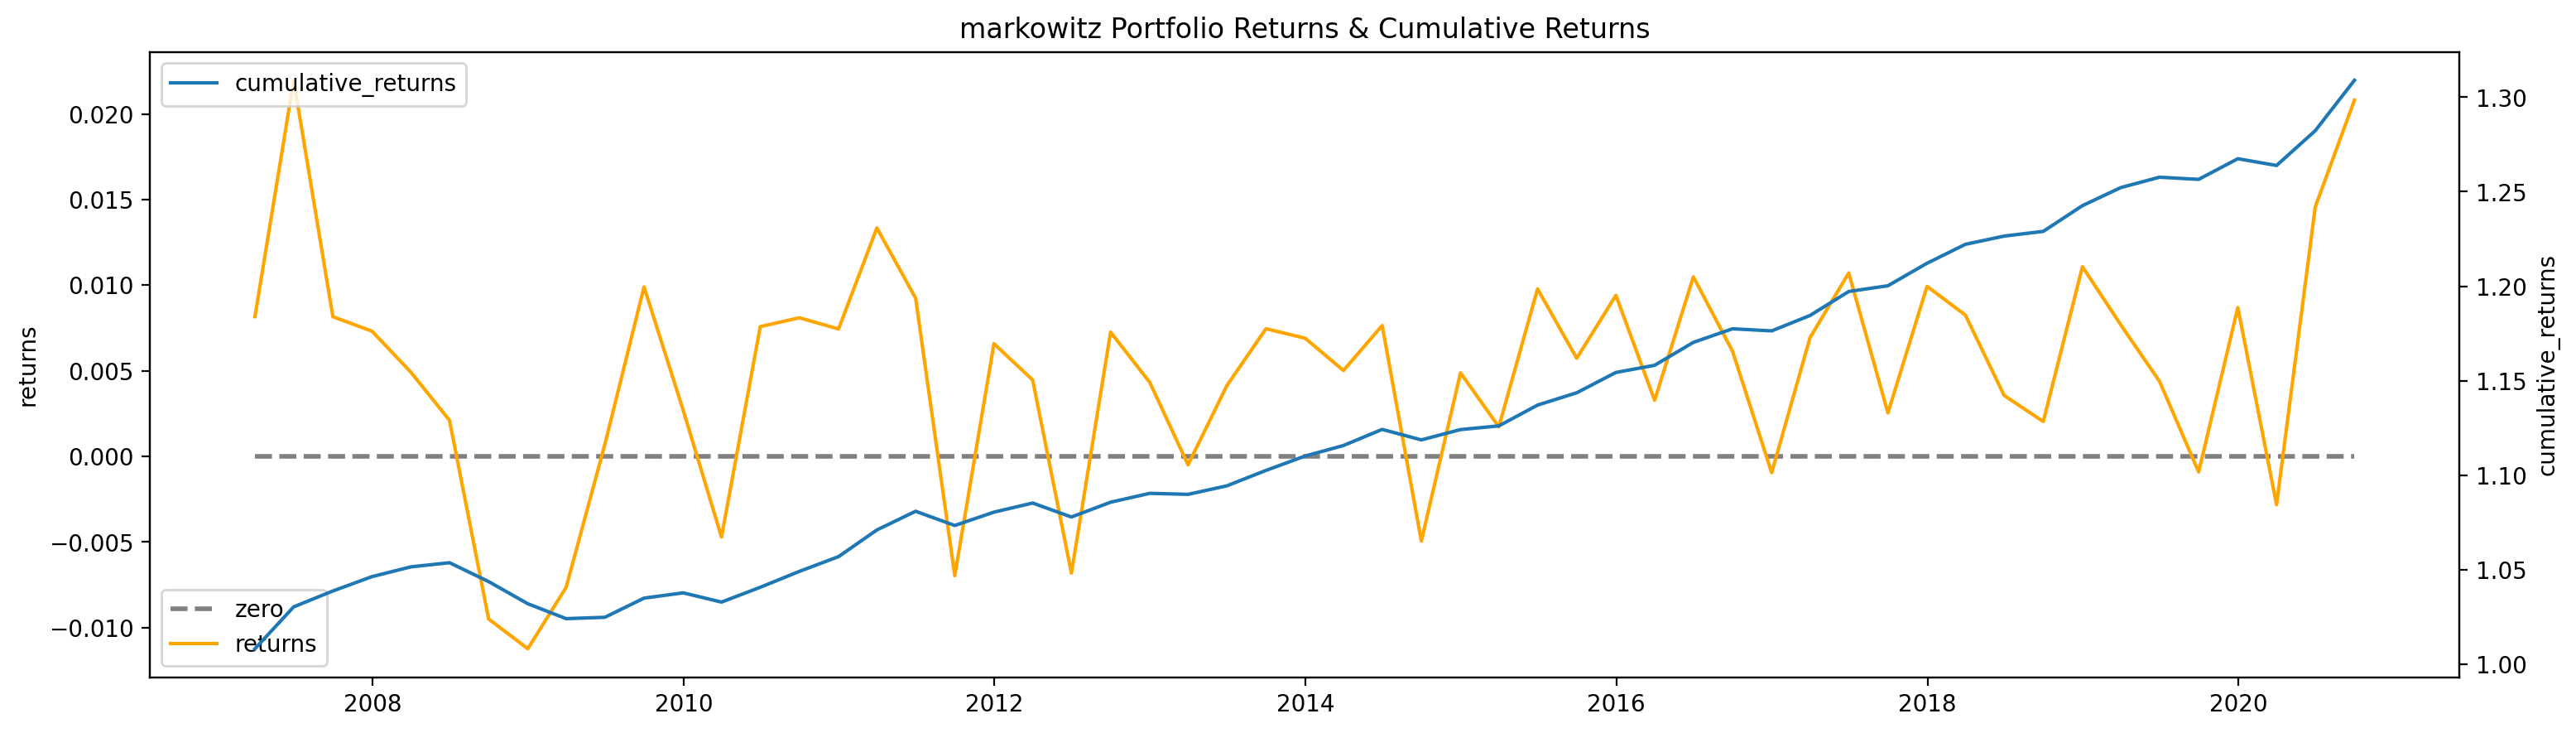

In [9]:
plot_portfolio_returns(asset_weights_markowitz, label='markowitz')

In [10]:
analyze_performance(asset_weights_markowitz)

Annually Return 10.028%,
 Annually Volatility 6.749%,
 Sharpe 1.189


- Markowitz with L2 norm

In [11]:
ef = EfficientFrontier(assets_return, assets_cov, weight_bounds=[-1,1])
ef.add_objective(objective_functions.L2_reg, gamma=0.1)
weights = ef.min_volatility()
cleaned_weights = ef.clean_weights()
asset_weights_markowitz_l2 = pd.DataFrame(cleaned_weights, index=['weights']).values[0]
asset_weights_markowitz_l2

array([0.20133, 0.19645, 0.2138 , 0.19957, 0.18885])

/Users/rickzhou/miniconda3/lib/python3.8/site-packages/riskfolio/src/PlotFunctions.py:605: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sizes2 = sizes2.append(item)


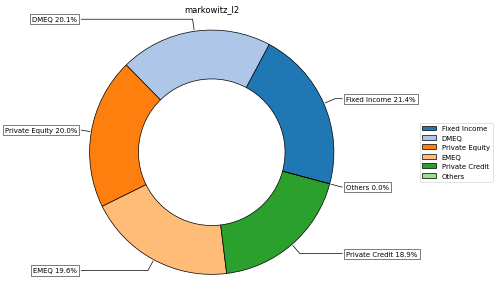

In [12]:
plot_asset_weights(asset_weights_markowitz_l2, label='markowitz_l2')

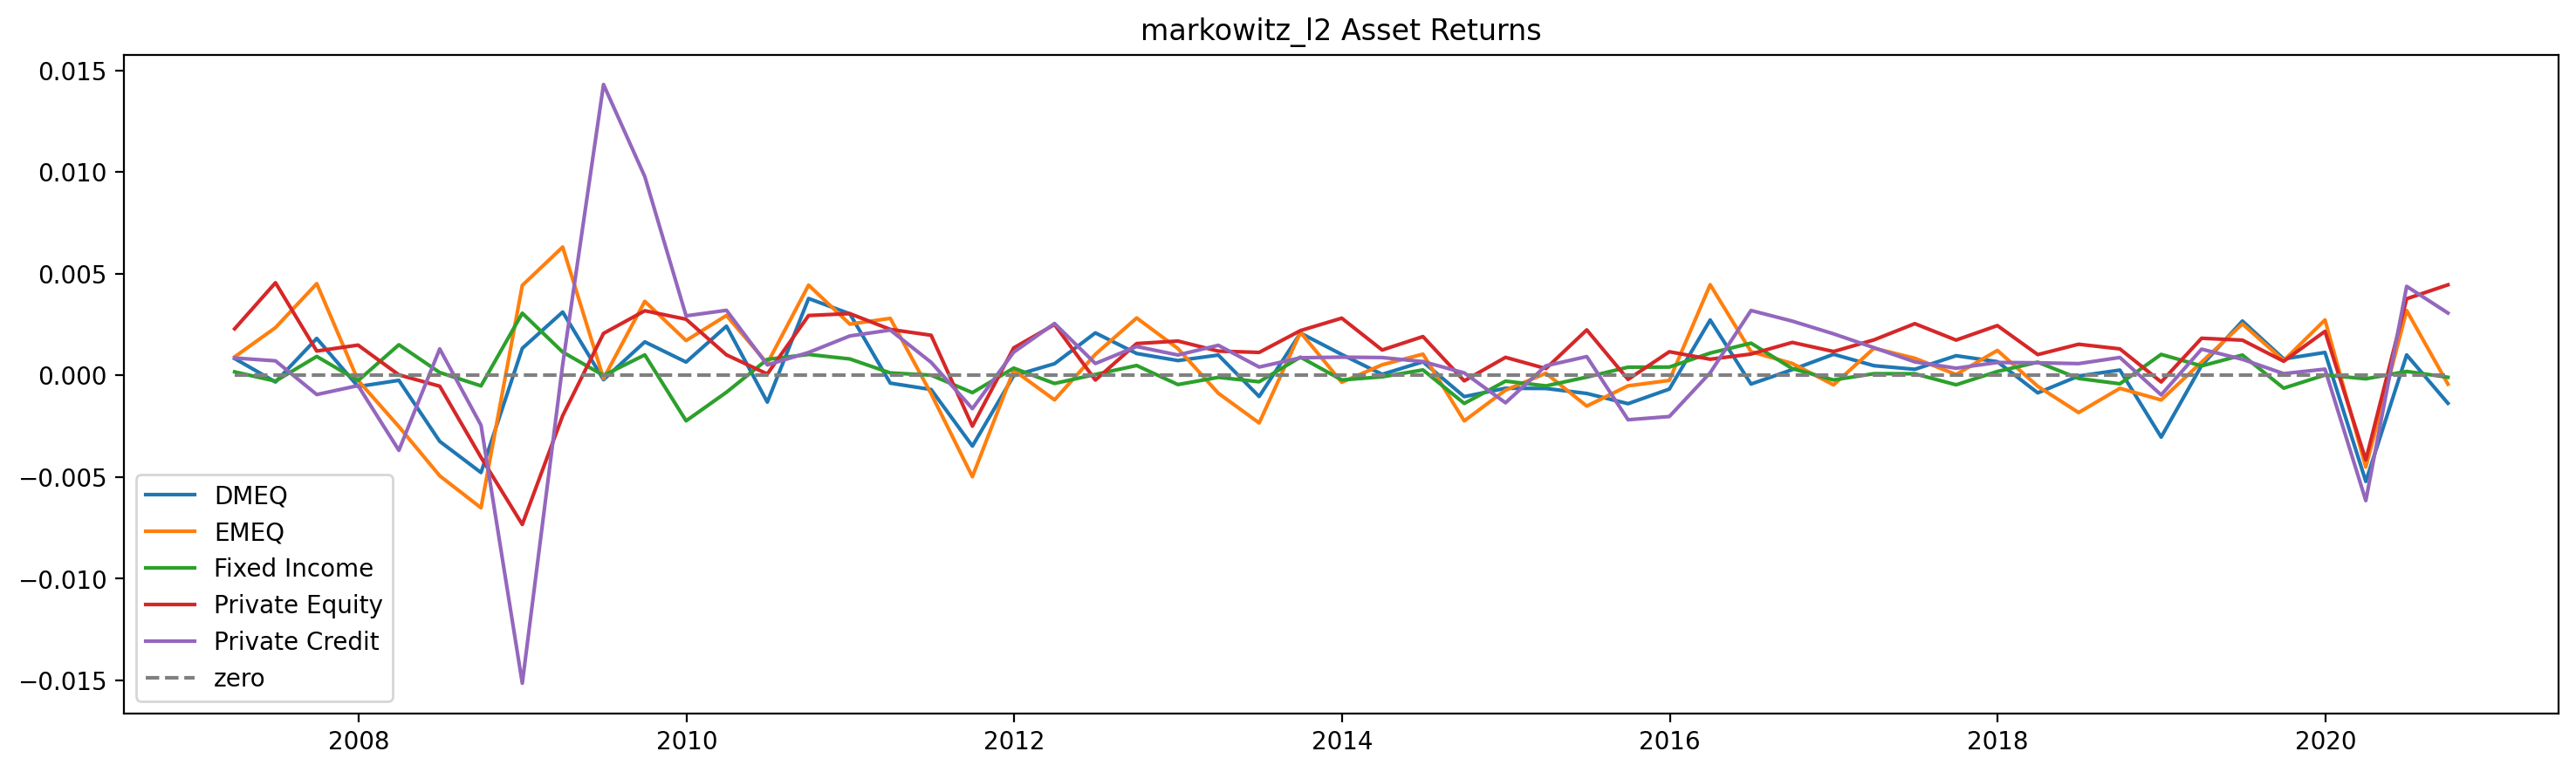

In [13]:
plot_asset_returns(asset_weights_markowitz_l2, label='markowitz_l2')

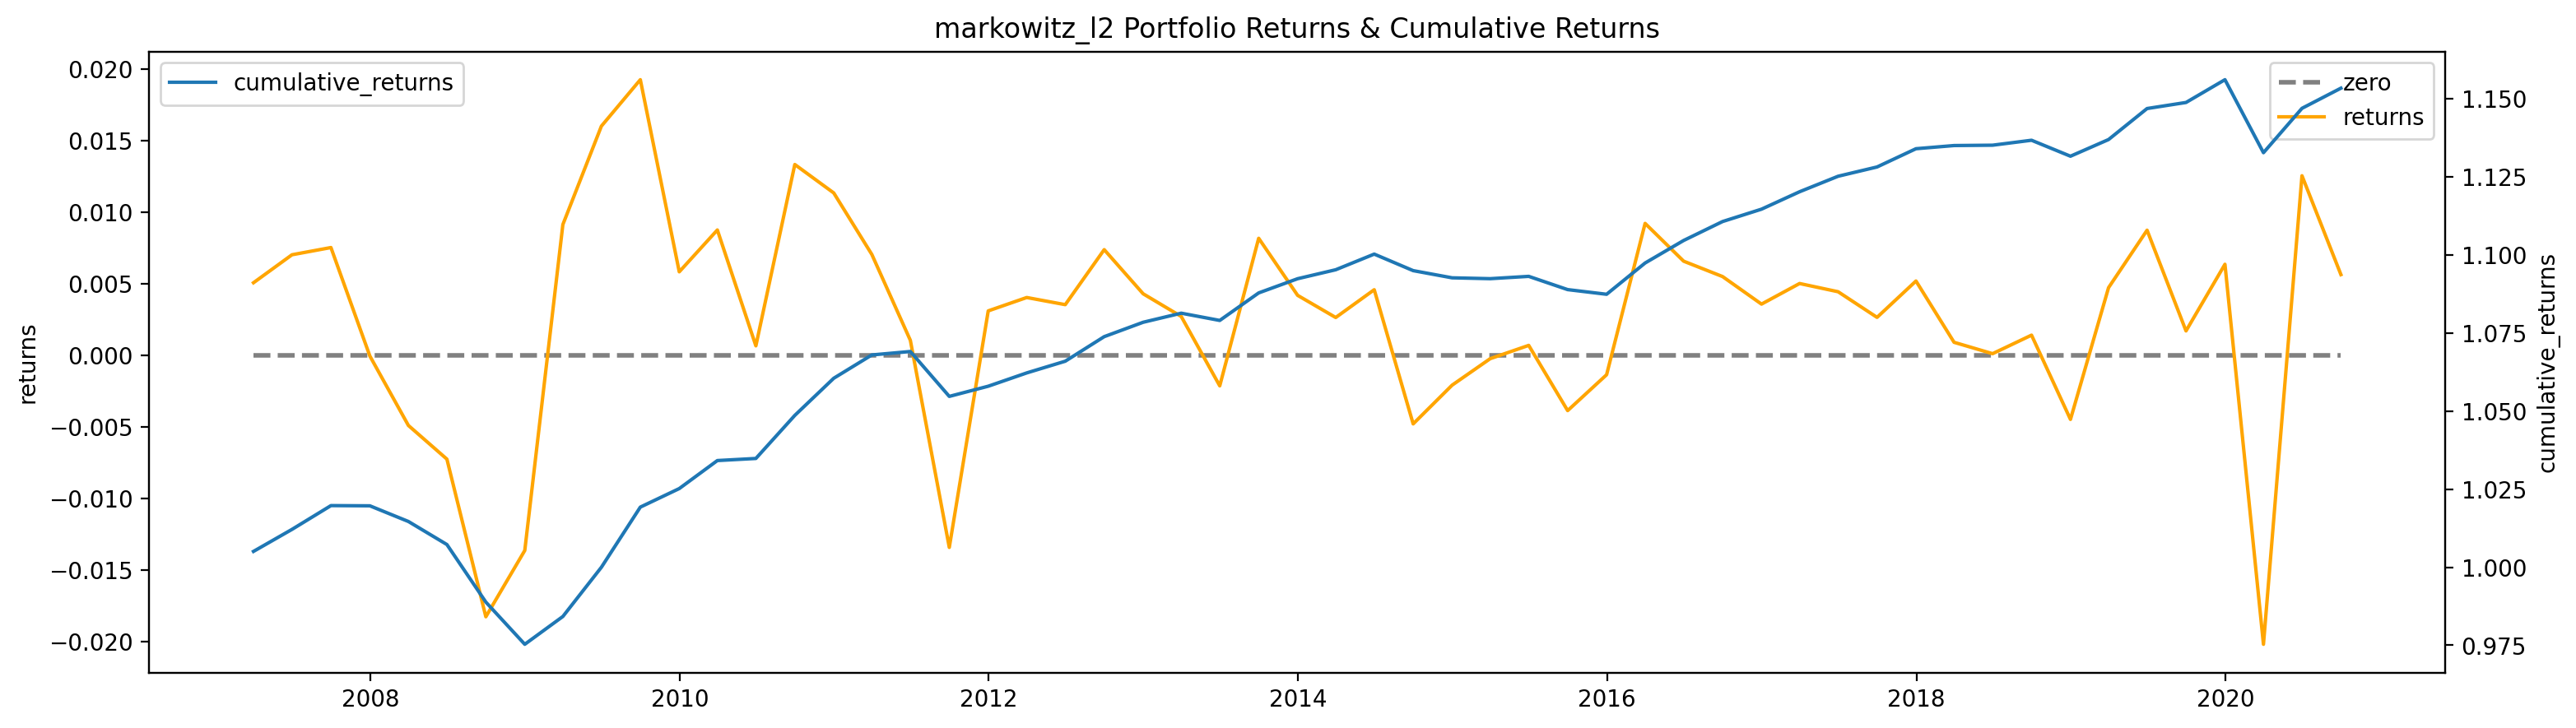

In [14]:
plot_portfolio_returns(asset_weights_markowitz_l2, label='markowitz_l2')

In [15]:
analyze_performance(asset_weights_markowitz_l2)

Annually Return 5.682%,
 Annually Volatility 7.566%,
 Sharpe 0.487


## 4 Risk-Parity Framework
- Risk-Parity Model

In [16]:
# Building the portfolio object
port = rp.Portfolio(returns=df_data)

# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

# Estimate optimal portfolio:

model='Classic' # Could be Classic (historical) or FM (Factor Model)
rm = 'MV' # Risk measure used, this time will be variance
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
b = None # Risk contribution constraints vector
w_rp = port.rp_optimization(model=model, rm=rm, rf=rf, b=b, hist=hist)

asset_weights_rp = w_rp.squeeze().values
print(asset_weights_rp)

[0.12757878 0.08882906 0.55401377 0.14017912 0.08939928]


/Users/rickzhou/miniconda3/lib/python3.8/site-packages/riskfolio/src/PlotFunctions.py:605: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sizes2 = sizes2.append(item)


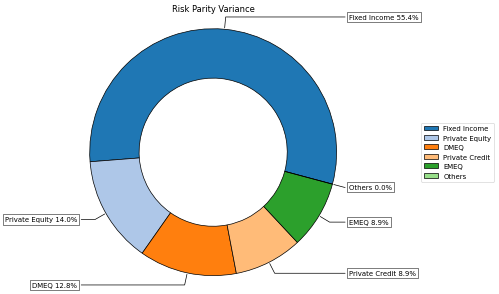

In [17]:
plot_asset_weights(w_rp, label='Risk Parity Variance')

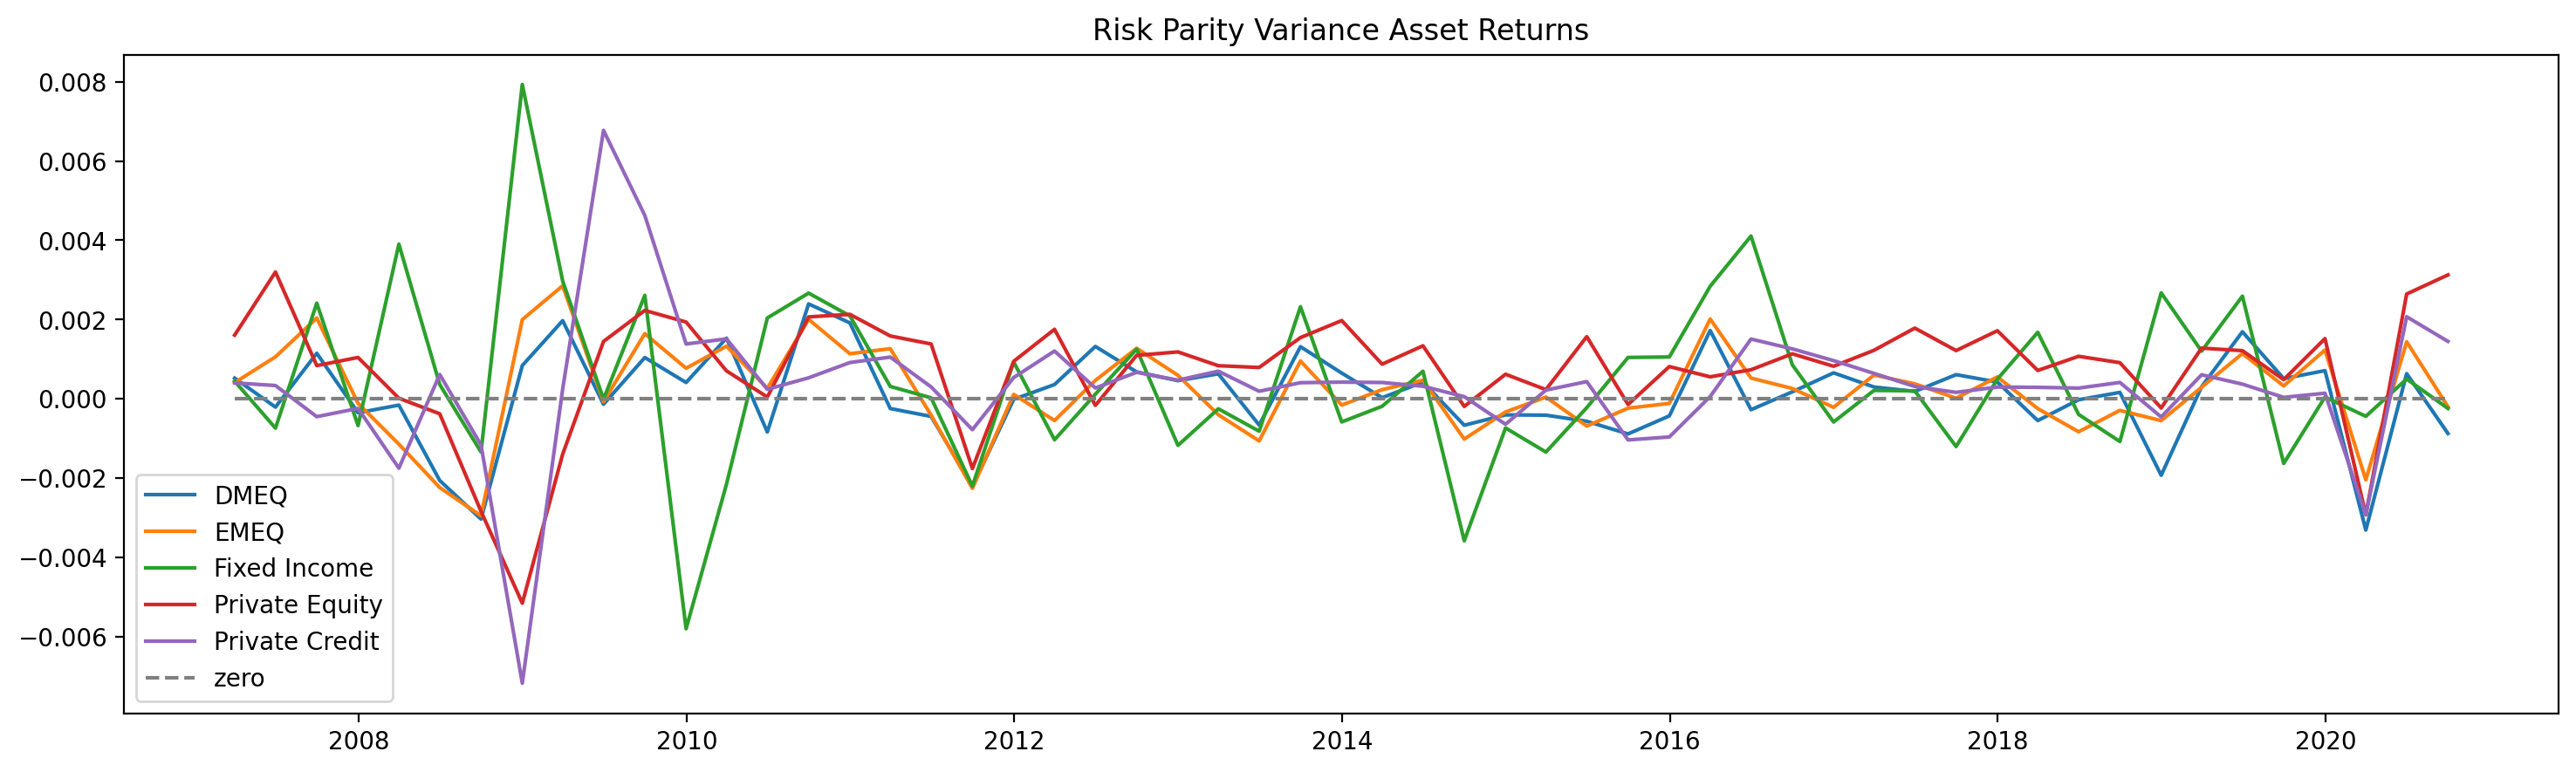

In [18]:
plot_asset_returns(asset_weights_rp, label='Risk Parity Variance')

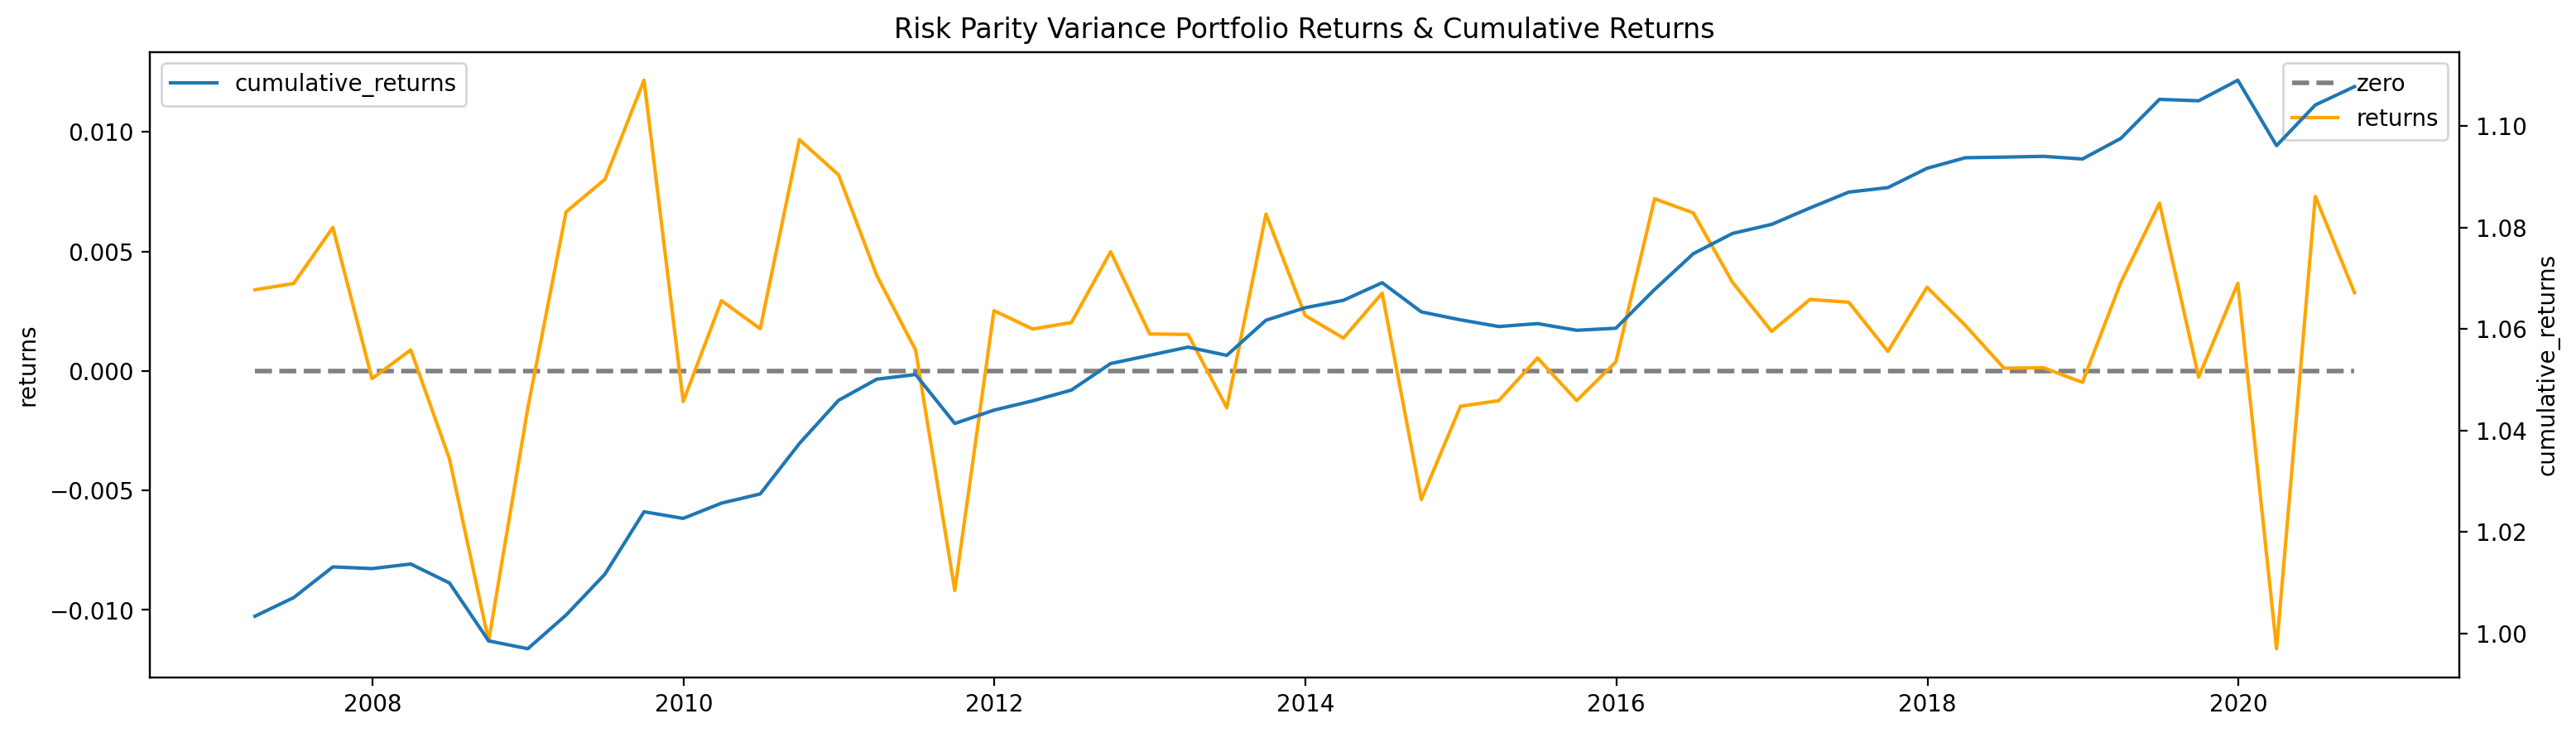

In [19]:
plot_portfolio_returns(asset_weights_rp, label='Risk Parity Variance')

In [20]:
analyze_performance(asset_weights_rp)

Annually Return 3.914%,
 Annually Volatility 4.623%,
 Sharpe 0.414


- Hierarchical Risk Parity Model

In [21]:
hro_optimizer = HRPOpt(returns=df_data, cov_matrix=assets_cov)

hro_optimizer.optimize()
cleaned_weights = hro_optimizer.clean_weights()
asset_weights_hrp = pd.DataFrame(cleaned_weights, index=['weights']).values[0]
asset_weights_hrp

array([0.07528, 0.0366 , 0.77062, 0.0906 , 0.02691])

/Users/rickzhou/miniconda3/lib/python3.8/site-packages/riskfolio/src/PlotFunctions.py:605: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sizes2 = sizes2.append(item)


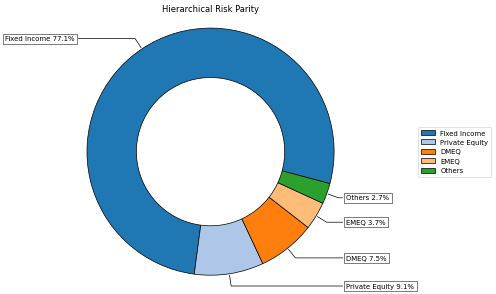

In [22]:
plot_asset_weights(asset_weights_hrp, label='Hierarchical Risk Parity')

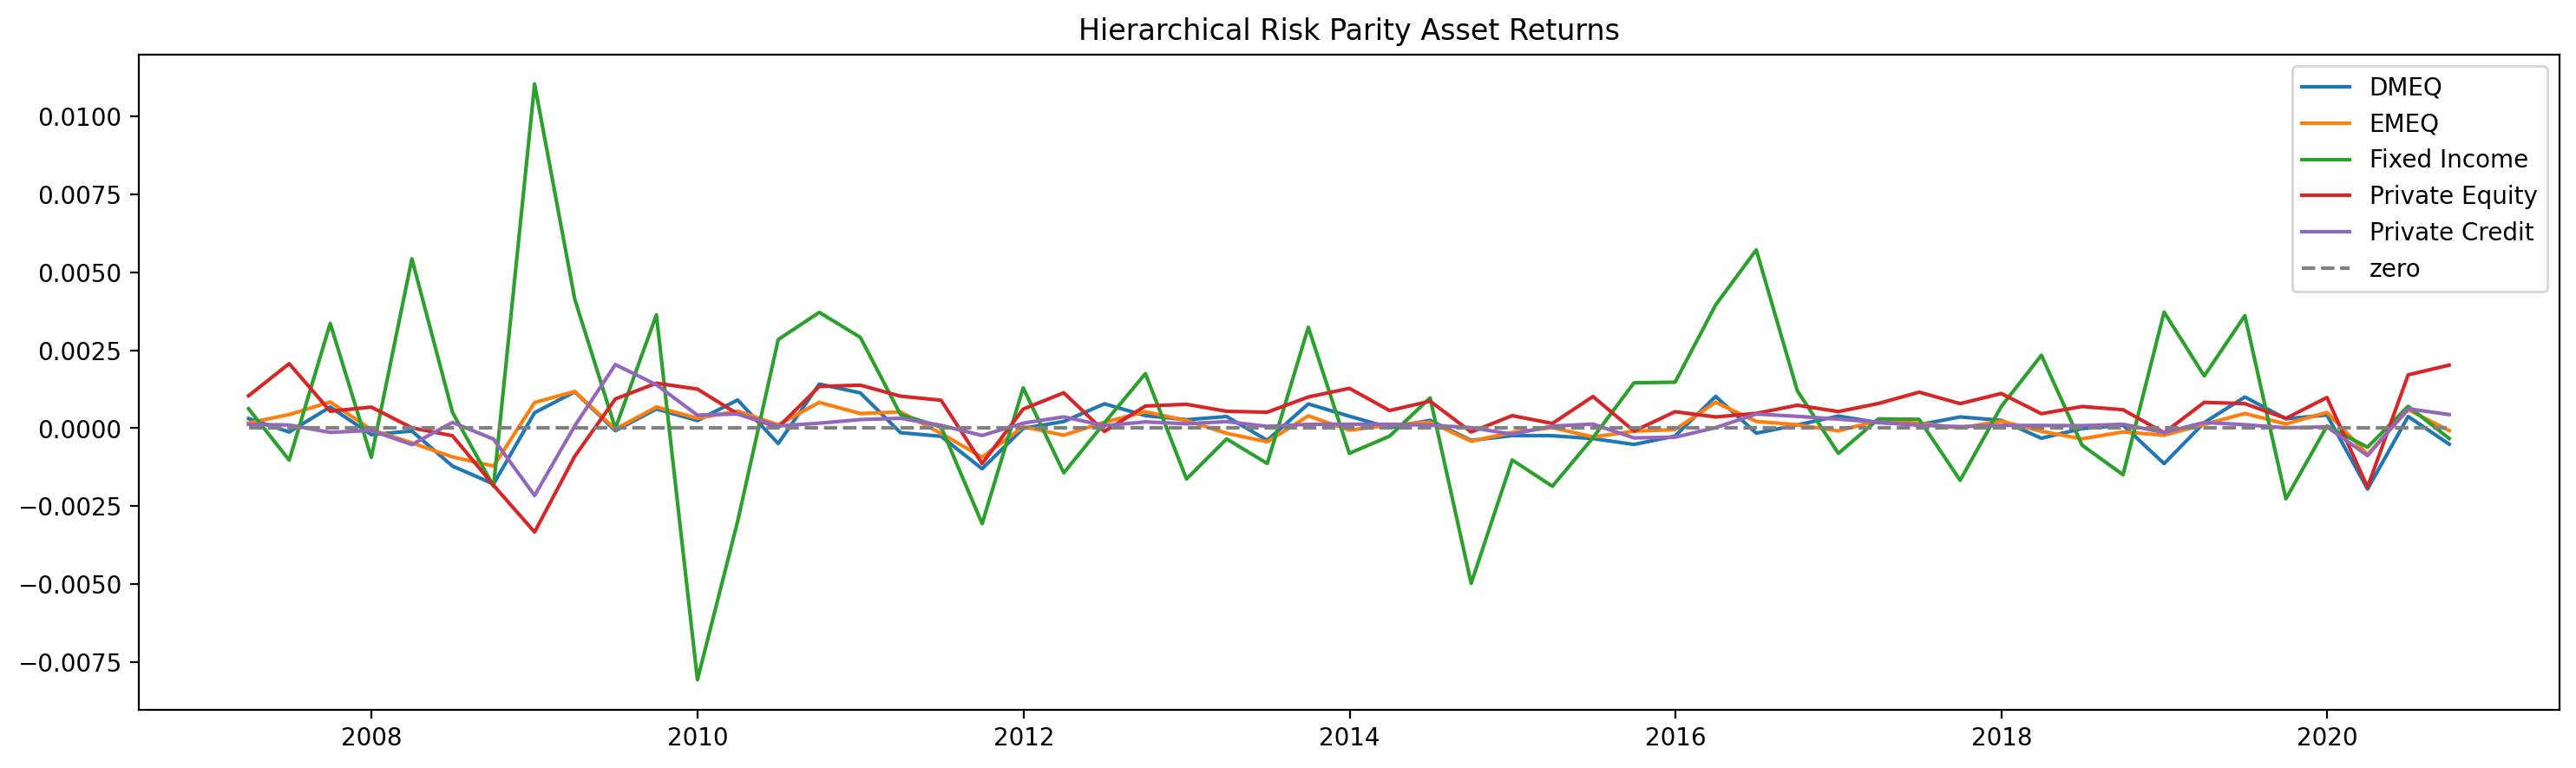

In [23]:
plot_asset_returns(asset_weights_hrp, label='Hierarchical Risk Parity')

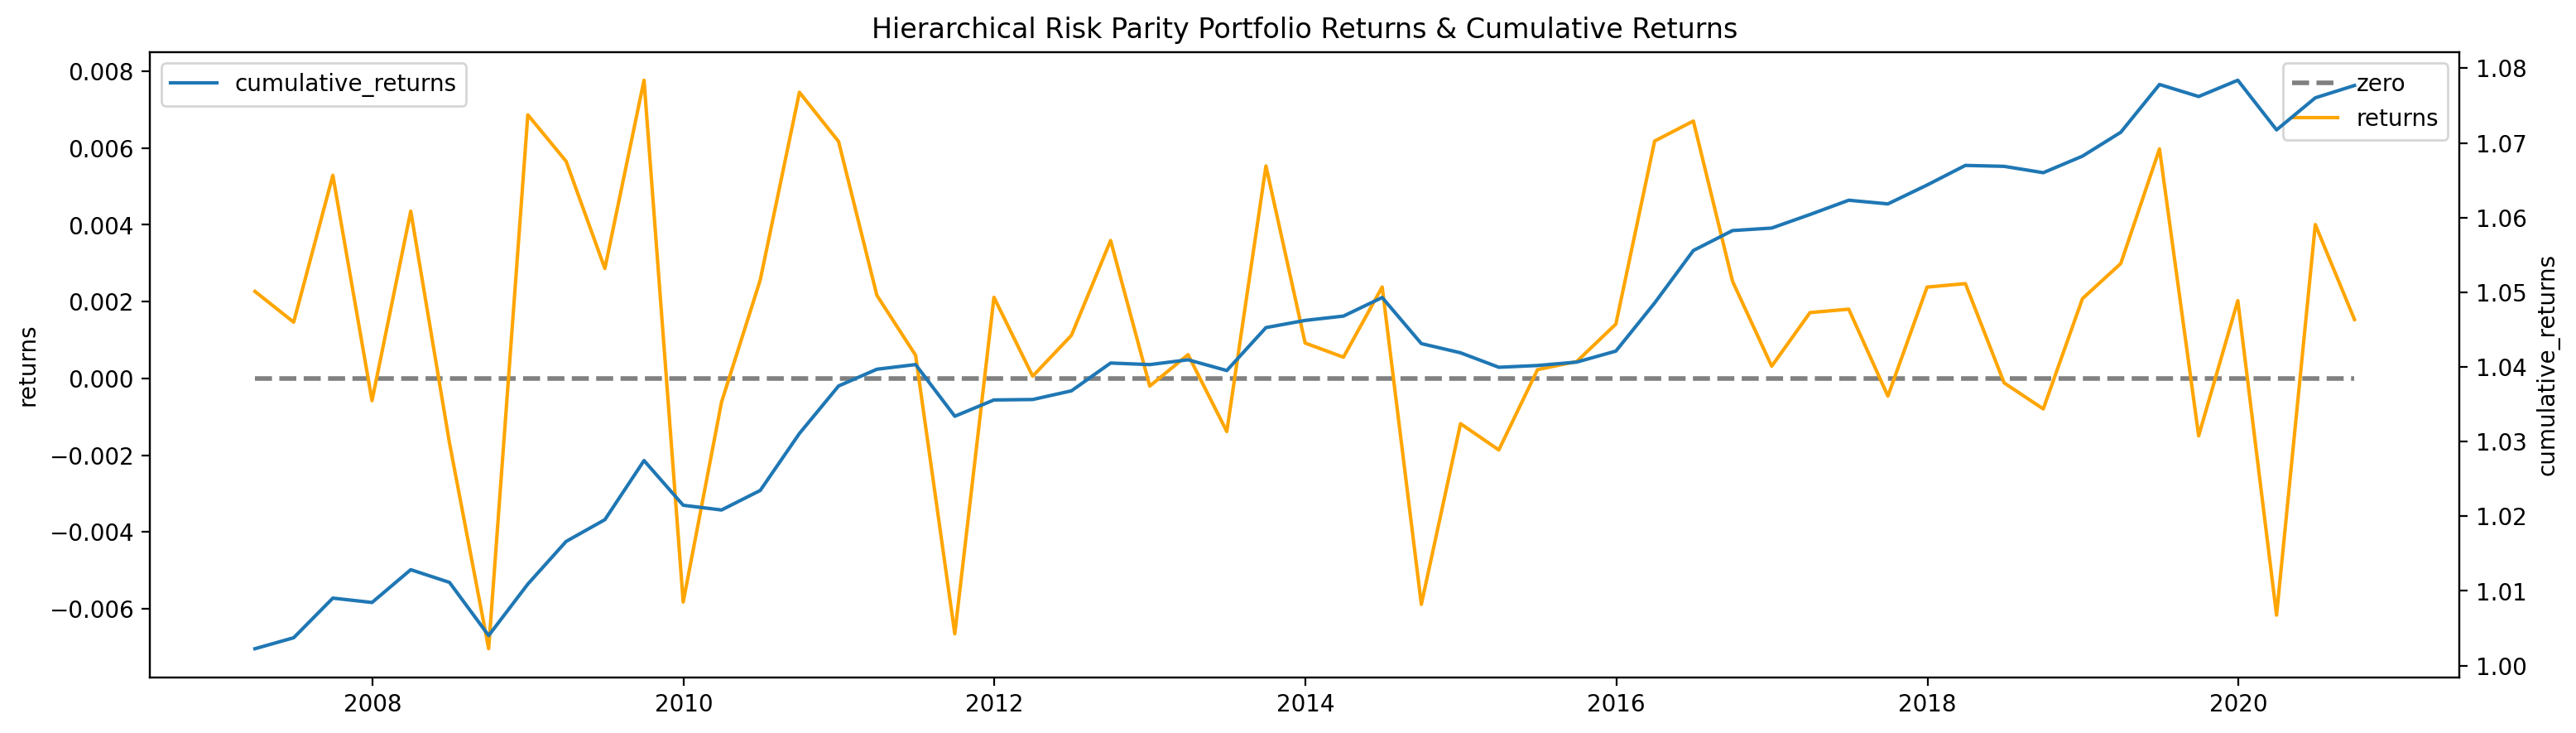

In [24]:
plot_portfolio_returns(asset_weights_hrp, label='Hierarchical Risk Parity')

In [25]:
analyze_performance(asset_weights_hrp)

Annually Return 2.727%,
 Annually Volatility 3.571%,
 Sharpe 0.204


## 5 Active mean-variance portfolio 

In [26]:
# calculate the asset weights of the active mv portfolio
delta_star = (assets_ones @ inv(assets_cov) @ assets_return)/(assets_ones @ inv(assets_cov) @ assets_ones)
asset_weights_active = 1/20 * (inv(assets_cov) @ (assets_return - delta_star * assets_ones))

In [27]:
asset_weights_active_mv = asset_weights_active + asset_weights_benchmark
print(asset_weights_active_mv)

[-0.49417226  0.61368108  0.11578939  0.89843929 -0.1337375 ]


/Users/rickzhou/miniconda3/lib/python3.8/site-packages/riskfolio/src/PlotFunctions.py:605: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sizes2 = sizes2.append(item)


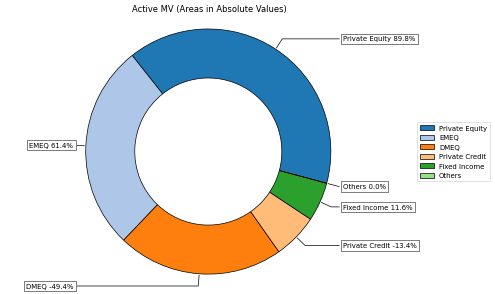

In [28]:
plot_asset_weights(asset_weights_active_mv, label='Active MV')

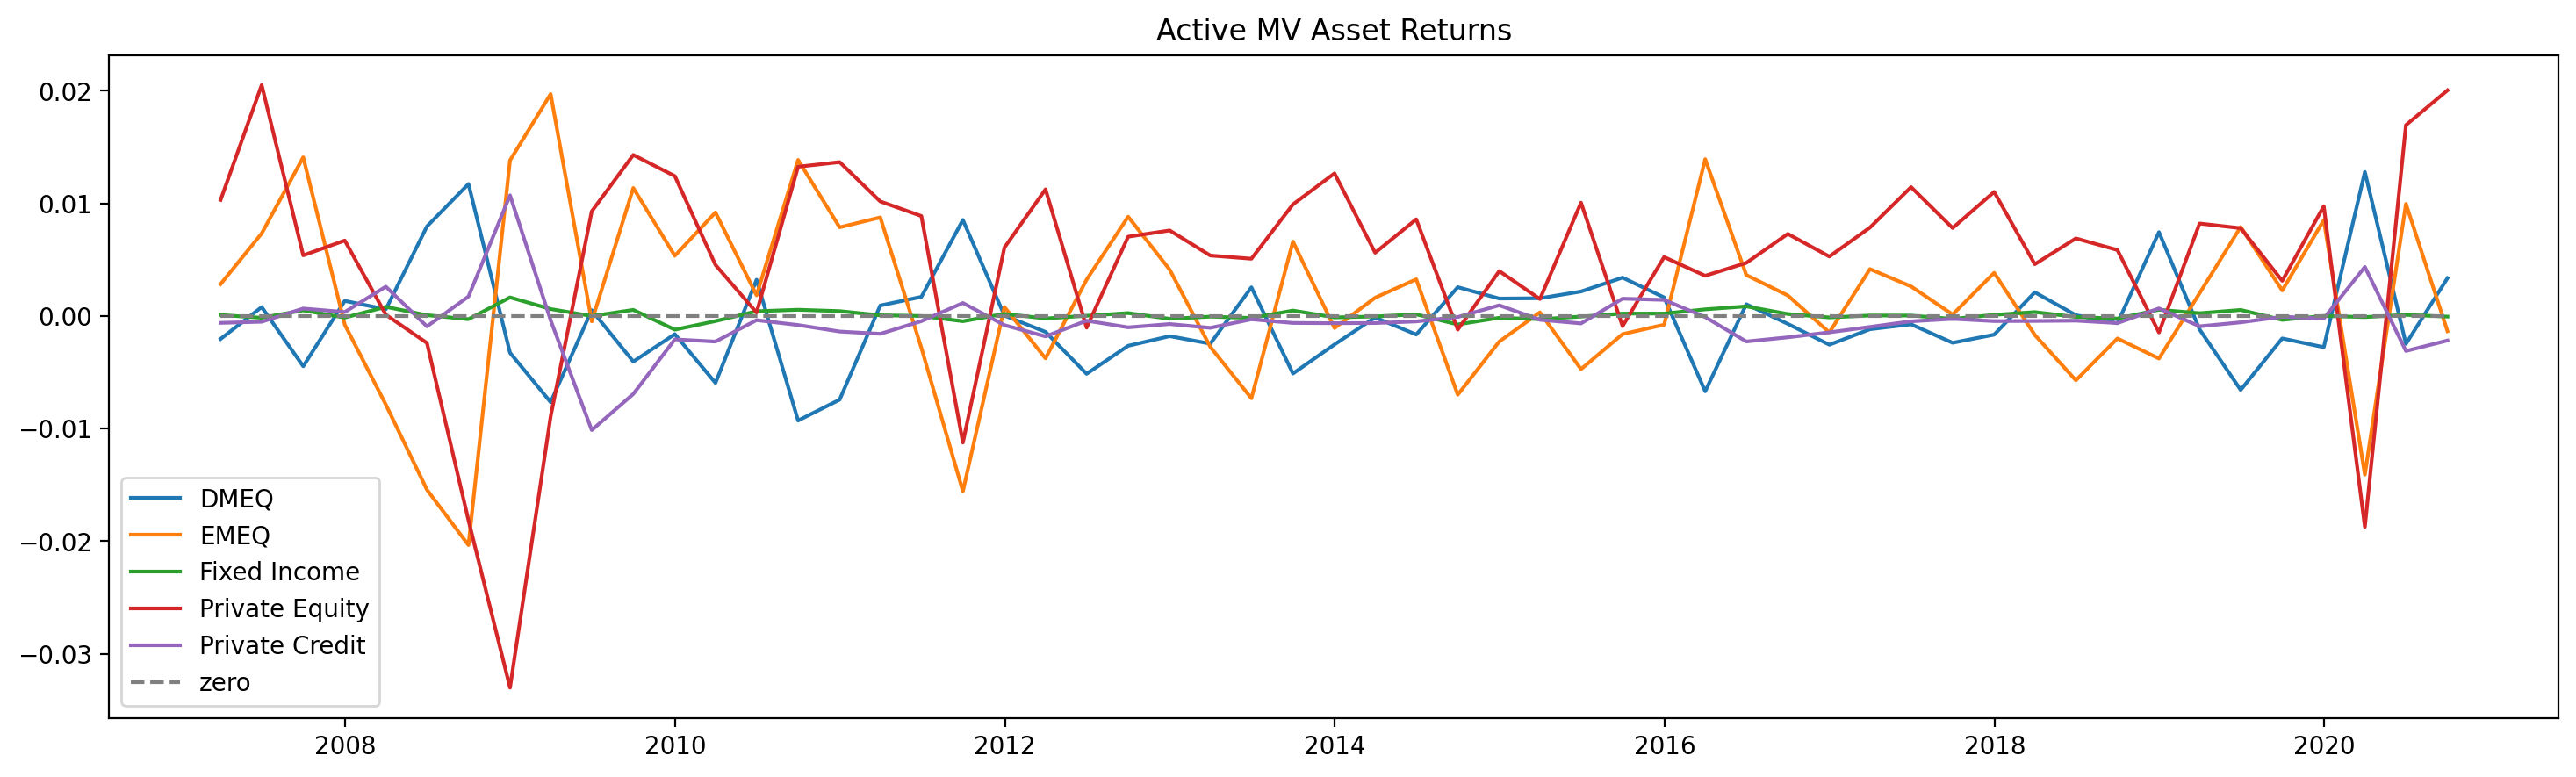

In [29]:
plot_asset_returns(asset_weights_active_mv, label='Active MV')

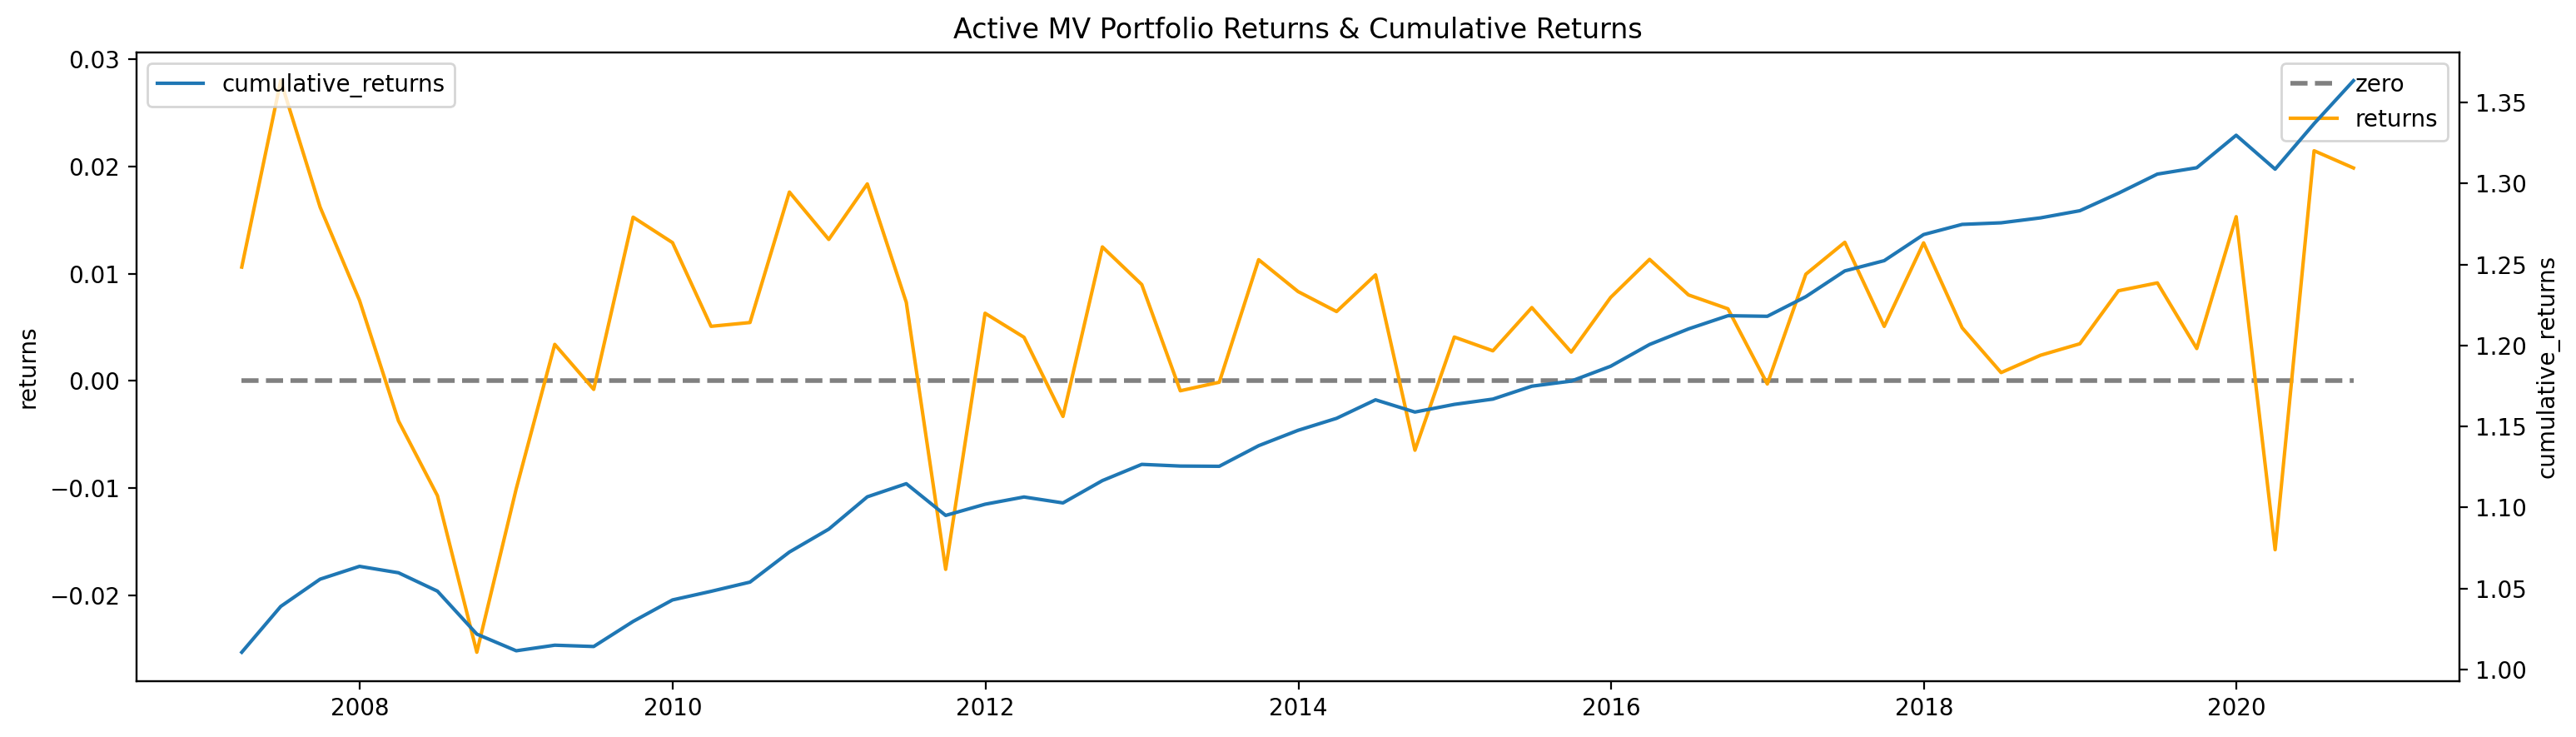

In [30]:
plot_portfolio_returns(asset_weights_active_mv, label='Active MV')

In [31]:
analyze_performance(asset_weights_active_mv)

Annually Return 11.690%,
 Annually Volatility 9.843%,
 Sharpe 0.984
